# Setup

In [ ]:
!pip install -qU langchain
!pip install -qU langchain-google-genai
!pip install -qU langchain-huggingface
!pip install -qU langchain-qdrant
!pip install -qU langchain-community
!pip install -qU langgraph
!pip install fastembed

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 18.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-generativeai 0.8.4 requires google-ai-generativelanguage==0.6.15, but you have google-ai-generativelanguage 0.6.17 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 53.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56

In [1]:
import os
from dotenv import load_dotenv
import pandas as pd
from pandas import DataFrame
import numpy as np
from tqdm import tqdm

load_dotenv()

# for colab
# from google.colab import userdata

# os.environ["GOOGLE_API_KEY"] = userdata.get('gemini_api_key')
# os.environ["HUGGINGFACE_API_KEY"] = userdata.get('huggingface_api_key')
# os.environ["LANGSMITH_API_KEY"] = userdata.get('langsmith_api_key')
# os.environ["LANGCHAIN_TRACING_V2"] = "true"
# os.environ["LANGSMITH_TRACING"] = "true"
# os.environ["LANGSMITH_PROJECT"] = "nlp_project"

True

In [2]:
from huggingface_hub import login

login(token=os.getenv("HUGGINGFACE_API_KEY"))
print("Logged in successfully!")

/Users/idhibhatpankam/Code/chula/capstone/grader-rag/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Logged in successfully!


In [3]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash-001")

In [4]:
llm.invoke("hi")

AIMessage(content='Hi there! How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-725c98e2-d2f1-45b9-9346-29a05423e01b-0', usage_metadata={'input_tokens': 1, 'output_tokens': 11, 'total_tokens': 12, 'input_token_details': {'cache_read': 0}})

In [5]:
from langchain_huggingface import HuggingFaceEmbeddings

model_kwargs = {'trust_remote_code': True}
embeddings = HuggingFaceEmbeddings(model_name="Alibaba-NLP/gte-modernbert-base", model_kwargs=model_kwargs)

In [6]:
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import CrossEncoderReranker
from langchain_community.cross_encoders import HuggingFaceCrossEncoder

model = HuggingFaceCrossEncoder(model_name="Alibaba-NLP/gte-reranker-modernbert-base")

## Loading data
- only include submissions with full score
- duplicate code (exact match) is not allowed for unknown/generated code
- duplicate code (only different variable names) is not allowed for human-written code

In [7]:
submissions = pd.read_csv("./data/submissions.csv")
submissions.groupby(["problem_id", "type"]).size().unstack(fill_value=0)

type,human,unknown
problem_id,,
05_List_11,2029,1304
08_Dict_22,2018,414


In [8]:
generated_submissions = pd.read_csv("./data/generated_submissions.csv")
generated_submissions.groupby("problem_id").size().reset_index(name="count")

,problem_id,count
0,05_List_11,62
1,08_Dict_22,378


In [9]:
submissions = pd.concat([submissions, generated_submissions], ignore_index=True)
submissions.groupby(["problem_id", "type"]).size().unstack(fill_value=0)

type,generated,human,unknown
problem_id,,,
05_List_11,62,2029,1304
08_Dict_22,378,2018,414


In [10]:
submissions

,id,author,problem_id,code,submission_id,score,time,type
0,1255109.0,6330139021,05_List_11,x = input()\na = [str(i) for i in range(10)]\n...,1255109.0,100.0,over 4 years ago,human
1,1257085.0,6330004021,05_List_11,"n=input()\nans=''\ndg=['0','1','2','3','4','5'...",1257085.0,100.0,over 4 years ago,human
2,1255424.0,6330015921,05_List_11,"a=input()\nb=[]\nc=""""\nfor ch in a:\n if""0""...",1255424.0,100.0,over 4 years ago,human
3,1047529.0,6230080521,05_List_11,"a=input().strip()\nn=['0','1','2','3','4','5',...",1047529.0,100.0,over 5 years ago,human
4,1253956.0,6231007021,05_List_11,"dg = ['0','1','2','3','4','5','6','7','8','9']...",1253956.0,100.0,over 4 years ago,human
...,...,...,...,...,...,...,...,...
6200,NaN,gemini-2.0-flash-001,08_Dict_22,def solve():\n n = int(input())\n ice_cr...,NaN,NaN,2025-03-21 19:43:16.459842,generated
6201,NaN,gemini-2.0-flash-001,08_Dict_22,def solve():\n n = int(input())\n prices...,NaN,NaN,2025-03-21 19:43:18.512018,generated
6202,NaN,gemini-2.0-flash-001,08_Dict_22,def solve():\n n = int(input())\n prices...,NaN,NaN,2025-03-21 19:43:20.765874,generated
6203,NaN,gemini-2.0-flash-001,08_Dict_22,def solve():\n n = int(input())\n ice_cr...,NaN,NaN,2025-03-21 19:43:49.863853,generated


In [11]:
rag_submissions = submissions[submissions["type"].isin(["human", "generated"])]
rag_submissions.groupby(["problem_id", "type"]).size().unstack(fill_value=0)

type,generated,human
problem_id,,
05_List_11,62,2029
08_Dict_22,378,2018


In [12]:
from typing import Tuple

import pandas as pd
from sklearn.model_selection import train_test_split


def split_dataframe(
    df: pd.DataFrame, stratify_cols: list[str], random_state: int = 42
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Splits the DataFrame into train/val/test while preserving the distribution of stratify_cols.

    Args:
        df (pd.DataFrame): The DataFrame to split.
        stratify_cols (list[str]): Columns to stratify by (e.g., ["problem_id", "type"]).
        random_state (int): Random seed for reproducibility.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]
    """
    df["_stratify_group"] = df[stratify_cols].astype(str).agg("_".join, axis=1)

    train_df, temp_df = train_test_split(
        df, test_size=0.2, stratify=df["_stratify_group"], random_state=random_state
    )

    val_df, test_df = train_test_split(
        temp_df,
        test_size=0.5,
        stratify=temp_df["_stratify_group"],
        random_state=random_state,
    )

    for d in (train_df, val_df, test_df):
        d.drop(columns="_stratify_group", inplace=True)

    return train_df, val_df, test_df


In [13]:
# from split_df import split_dataframe

train_df, val_df, test_df = split_dataframe(rag_submissions, stratify_cols=["problem_id", "type"], random_state=42)

train_df.shape, val_df.shape, test_df.shape

/var/folders/27/0_8pjdb52g91gmnzbtgblvgc0000gn/T/ipykernel_90440/236710213.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["_stratify_group"] = df[stratify_cols].astype(str).agg("_".join, axis=1)


((3589, 8), (449, 8), (449, 8))

In [14]:
train_counts = train_df.groupby(["problem_id", "type"]).size().unstack(fill_value=0)
val_counts = val_df.groupby(["problem_id", "type"]).size().unstack(fill_value=0)
test_counts = test_df.groupby(["problem_id", "type"]).size().unstack(fill_value=0)

combined = pd.concat(
    [train_counts, val_counts, test_counts],
    axis=1,
    keys=["Train", "Validation", "Test"]
)

print(combined)

               Train       Validation            Test      
type       generated human  generated human generated human
problem_id                                                 
05_List_11        50  1623          6   203         6   203
08_Dict_22       302  1614         38   202        38   202


## Local

In [15]:
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams

client = QdrantClient(host="localhost", port=6333)

if not client.collection_exists("submission_collection"):
    print("Creating collection...")
    client.create_collection(
        collection_name="submission_collection",
        vectors_config=VectorParams(size=768, distance=Distance.COSINE),
    )

vector_store = QdrantVectorStore(
    client=client,
    collection_name="submission_collection",
    embedding=embeddings,
)

## Colab GPUs

In [ ]:
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams

client = QdrantClient(path="qdrant_storage")

if not client.collection_exists("submission_collection"):
    print("Creating collection...")
    client.create_collection(
        collection_name="submission_collection",
        vectors_config=VectorParams(size=768, distance=Distance.COSINE),
    )

vector_store = QdrantVectorStore(
    client=client,
    collection_name="submission_collection",
    embedding=embeddings,
)

### Run this only when you want to re-index the data
- the existing will be in `qdrant_storage` folder

In [ ]:
from langchain_core.documents import Document

all_docs = [
    Document(page_content=code, metadata={"problem_id": problem_id, "author": author, "type": _type})
    for code, problem_id, author, _type in zip(
        list(train_df["code"]),
        train_df["problem_id"],
        train_df["author"],
        train_df["type"])
]
print(len(all_docs))

In [33]:
import math

batches = math.ceil(len(all_docs) / 10)
for i in tqdm(range(batches)):
    start = i * 10
    end = min((i + 1) * 10, len(all_docs))
    vector_store.add_documents(all_docs[start:end])

100%|██████████| 359/359 [24:01<00:00,  4.01s/it]


## Retriever

In [16]:
# Maximal Marginal Relevance (MMR) is a hybrid search
retriever_mmr = vector_store.as_retriever(
    search_type="mmr",
    search_kwargs={"k": 20, "fetch_k": 20, "lambda_mult": 0.5},
)

query = generated_submissions.iloc[0]["code"]

print("\nMMR Retriever Results:")
res_mmr = retriever_mmr.invoke(query)
for i in range(3):
    print(res_mmr[i].metadata)


MMR Retriever Results:
{'author': 'gemini-2.0-flash-001', 'problem_id': '05_List_11', 'type': 'generated', '_id': 'e13a7470-6481-4463-afdc-33d6af8739f9', '_collection_name': 'submission_collection'}
{'author': 'gemini-2.0-flash-001', 'problem_id': '05_List_11', 'type': 'generated', '_id': 'a19df4e3-d303-4a51-852c-4e931b0c156d', '_collection_name': 'submission_collection'}
{'author': '6330096721', 'problem_id': '05_List_11', 'type': 'human', '_id': 'b48da99f-90ce-4561-9158-148886ad91d3', '_collection_name': 'submission_collection'}


In [17]:
generated_submissions.iloc[0]

id                                                             NaN
author                                        gemini-2.0-flash-001
problem_id                                              05_List_11
code             s = input()\nmissing = []\nfor i in range(10):...
submission_id                                                  NaN
score                                                          NaN
time                                    2025-04-28 22:43:32.473922
type                                                     generated
Name: 0, dtype: object

## Agentic RAG

In [19]:
system_message_content = """
You are an expert in analyzing Python code to determine whether it was written by a human or an AI model (LLM). 
You will be provided with a Python code snippet along with similar code submissions and their known authorship (either human or AI-generated). 
Your task is to classify the given code as either 'Human-Written' or 'Generated' based on its characteristics and similarities to the provided examples.

Consider the following factors in your decision-making process:

Human-Written Code Characteristics:
- Inconsistent formatting or indentation.
- Variable and function names that may lack clarity or best practices.
- Comments that are informal, inconsistent, or sometimes missing.
- Presence of debugging prints, unused variables, or inline TODOs.
- Non-standard implementations or creative deviations from best practices.
- Occasional syntax mistakes, missing imports, or inefficient logic.

Generated Code Characteristics:
- Consistently formatted, well-structured, and follows PEP 8 guidelines.
- Uses clear, descriptive, and best-practice variable and function names.
- Contains well-structured, formal comments, often explaining obvious code behavior.
- Implements well-known algorithms with clean and optimal solutions.
- Avoids common human errors like typos, syntax mistakes, and missing imports.
- Shows uniform style across different parts of the code, often lacking creative deviations.

Comparison with Similar Code Submissions:
- You will be provided with similar code submissions that have been previously classified as either 'Human-Written' (a 10-character student ID e.g. 6330117221) or 'Generated' (e.g. gemini-2.0-flash-001).
- Compare the given code against these examples to detect similarities in structure, logic, formatting, and commenting style.
- If the code closely resembles an AI-generated example in structure and style, it is more likely to be AI-generated.
- If it contains human-like inconsistencies or creative variations, it is more likely to be human-written.

Expected Output Format:
- Classification: "Human-Written" or "Generated"
- Justification: A brief explanation of the key observations leading to this classification. Mention specific patterns, inconsistencies, or similarities to known examples.

Analyze carefully and provide a well-reasoned classification.
"""

In [20]:
from langgraph.graph import MessagesState, StateGraph

graph_builder = StateGraph(MessagesState)

In [21]:
from langchain_core.tools import tool


@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve similar code submissions with author (human or LLM) to compare with input code."""
    retrieved_docs = retriever_mmr.invoke(query)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

In [22]:
from google.api_core import retry
import google.generativeai as genai

# Catch transient Gemini errors.
def is_retryable(e) -> bool:
    if retry.if_transient_error(e):
        # Good practice, but probably won't fire with the google-genai SDK
        return True
    elif (isinstance(e, genai.errors.ClientError) and e.code == 429):
        # Catch 429 quota exceeded errors
        return True
    elif (isinstance(e, genai.errors.ServerError) and e.code == 503):
        # Catch 503 model overloaded errors
        return True
    else:
        return False

In [23]:
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode
from langsmith import traceable


# Step 1: Generate an AIMessage that may include a tool-call to be sent.
@traceable
@retry.Retry(predicate=is_retryable)
def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond."""
    if not state["messages"]:
        raise ValueError("Error: No user message provided in state['messages'].")
    
    system_message = SystemMessage(content=system_message_content)
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke([system_message] + state["messages"])
    # MessagesState appends messages to state instead of overwriting
    return {"messages": [response]}

tools = ToolNode([retrieve])

# Step 3: Generate a response using the retrieved content.
@traceable
@retry.Retry(predicate=is_retryable)
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages) if tool_messages else "No similar code submissions found."
    system_prompt = (
        "Example code submissions with authorship (either human or AI-generated): "
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_prompt)] + conversation_messages

    # Run
    response = llm.invoke(prompt)
    return {"messages": [response]}

In [24]:
from langgraph.graph import END
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
# graph_builder.add_conditional_edges(
#     "query_or_respond",
#     tools_condition,
#     {END: END, "tools": "tools"},
# )
graph_builder.add_edge("query_or_respond", "tools")
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

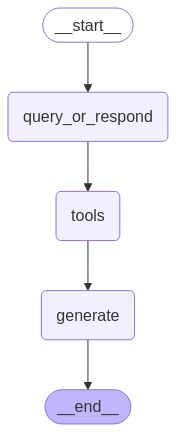

In [25]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [26]:
from langgraph.checkpoint.memory import MemorySaver

# memory = MemorySaver()
graph = graph_builder.compile()

# Specify an ID for the thread
config = {"configurable": {"thread_id": "abc123"}}

In [28]:
user_message_content = """
Here is the code snippet to analyze:
{code}

Please classify it as either 'Human-Written' or 'AI-Generated' based on the characteristics and similarities to the provided examples.
Use the tool to retrieve similar code submissions and their authorship for comparison.
Answer in the format:
Classification: "Human-Written" or "AI-Generated"
Justification: A brief explanation of the key observations leading to this classification. Mention specific patterns, inconsistencies, or similarities to known examples.
"""

In [30]:
test_df.iloc[0]

id                                                       1644593.0
author                                                  6531311021
problem_id                                              08_Dict_22
code             N = int(input())\nice = {}\nnew={}\nfor i in r...
submission_id                                            1644593.0
score                                                        100.0
time                                              over 2 years ago
type                                                         human
Name: 3854, dtype: object

In [29]:
input_message = user_message_content.format(code=test_df['code'].iloc[0])

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    for msg in step["messages"]:
        msg.pretty_print()
    # step["messages"][-1].pretty_print()

================================ Human Message =================================


Here is the code snippet to analyze:
N = int(input())
ice = {}
new={}
for i in range(N):
    name, pri = input().strip().split()
    ice[name] = pri
M = int(input())
total = 0
for i in range(M):
    sale, qual = input().strip().split()
    if sale in ice:
        if sale not in new:
            new[sale] = float(ice[sale])*(float(qual))
        else:
            new[sale] += int(ice[sale])*(float(qual))
        total += float(ice[sale])*float(qual)
if total>0:
    new = sorted(new.items(), key = lambda x:x[1], reverse=True)
    top = [new[0][0]] #'Top sales: ' + new[0][0]
    for i in range(1,len(new)):
        if new[i][1]==new[i-1][1]:
            top.append(new[i][0])
        else:
            break
        top.sort()
    print('Total ice cream sales:', total)
    print('Top sales: ', ', '.join(top))
else:
    print('No ice cream sales')

Please classify it as either 'Human-Written' or 'AI-Generated' 

In [32]:
test_df['problem_id'].value_counts()

problem_id
08_Dict_22    240
05_List_11    209
Name: count, dtype: int64

In [39]:
result_df = pd.DataFrame(columns=["problem_id", "submission_id", "code", "author", "type", "classification", "justification"])

In [40]:
test_df

,id,author,problem_id,code,submission_id,score,time,type
3854,1644593.0,6531311021,08_Dict_22,N = int(input())\nice = {}\nnew={}\nfor i in r...,1644593.0,100.0,over 2 years ago,human
5697,1447234.0,6430025221,08_Dict_22,n=int(input())\nic={}\nfor i in range(n):\n ...,1447234.0,100.0,over 3 years ago,human
1289,992372.0,6130368721,05_List_11,"n = list(input())\na = ['0','1','2','3','4','5...",992372.0,100.0,over 5 years ago,human
4011,1269814.0,6230103321,08_Dict_22,n = int(input())\nice={}\n\nfor i in range(n):...,1269814.0,100.0,over 4 years ago,human
5142,1749904.0,6530281621,08_Dict_22,def check_buy(x) :\n l = {}\n for e in x...,1749904.0,100.0,almost 2 years ago,human
...,...,...,...,...,...,...,...,...
2267,1292717.0,6331118021,05_List_11,"a = ['0', '1', '2', '3', '4', '5', '6', '7', '...",1292717.0,100.0,over 4 years ago,human
2308,1532052.0,6432155521,05_List_11,"mango = input()\nmangospace = "" "".join(mango)\...",1532052.0,100.0,about 3 years ago,human
4895,1449585.0,6431515621,08_Dict_22,MN = {}\nfor i in range (int(input())):\n i...,1449585.0,100.0,over 3 years ago,human
2723,1744253.0,6530223221,05_List_11,"s = input()\nx = []\n[0,1,2,3,4,5,6,7,8,9]\nfo...",1744253.0,100.0,about 2 years ago,human


In [ ]:
pbar = tqdm(total=len(test_df[:1]))
i = 0

while i < len(test_df[:1]):
    row = test_df.iloc[i]
    submission_id = row["submission_id"]
    problem_id = row["problem_id"]
    code = row["code"]
    author = row["author"]
    _type = row["type"]

    input_message = user_message_content.format(code=code)
    last_step = None

    for step in graph.stream(
        {"messages": [{"role": "user", "content": input_message}]},
        stream_mode="values",
        config=config,
    ):
        last_step = step 

    if last_step:
        prediction = last_step["messages"][-1].content.split("\n")
        classification = prediction[0].split(": ")[1].strip().replace('"', "")
        predicted_type = "human" if classification == "Human-Written" else "generated"
        justification = "\n".join(prediction[1:]).split(": ")[1].strip()
        result_df.loc[len(result_df)] = [problem_id, submission_id, code, author, _type, predicted_type, justification]
        
    i += 1
    pbar.update(1)

pbar.close()

100%|██████████| 1/1 [00:04<00:00,  4.94s/it]


In [46]:
result_df

,problem_id,submission_id,code,author,type,classification,justification
0,08_Dict_22,1644593.0,N = int(input())\nice = {}\nnew={}\nfor i in r...,6531311021,human,Human-Written,The code exhibits several characteristics comm...
1,08_Dict_22,1644593.0,N = int(input())\nice = {}\nnew={}\nfor i in r...,6531311021,human,human,The code exhibits several characteristics typi...
2,08_Dict_22,1644593.0,N = int(input())\nice = {}\nnew={}\nfor i in r...,6531311021,human,human,The code exhibits several characteristics comm...


In [ ]:
result_df.to_csv("./data/prediction_rag.csv", index=False)

In [ ]:
result_df[result_df["classification"] == "generated"]

,submission_id,code,author,classification,justification


In [ ]:
result_df[result_df["classification"] == "human"]

,submission_id,code,author,classification,justification
0,1547807,"def arrange(l):\n ll = []\n for no,name ...",6231211621,Human-Written,The code exhibits several characteristics typi...
1,1827099,n = int(input())\ndata = {}\nfor i in range(n)...,6631334521,Human-Written,The code exhibits several characteristics comm...
2,1923511,icecream={}\nmoney={}\nans=0\nn=int(input())\n...,6630163321,Human-Written,The code exhibits several characteristics comm...
3,1167126,n=int(input())\nb={}\nfor i in range(n):\n ...,6230250921,Human-Written,The code exhibits characteristics commonly fou...
4,1935535,iandp = {}\nfor k in range(int(input())):\n ...,6630296121,Human-Written,The code exhibits several characteristics typi...
...,...,...,...,...,...
124,1165391,n = int(input())\nmenu = {} ; sale = {}\nfor i...,6230361921,Human-Written,The code exhibits several characteristics comm...
125,1923085,n = int(input())\nkai = {}\nfor i in range(n):...,6630214721,Human-Written,The code exhibits several characteristics of h...
126,1922478,np=int(input())\npi={}\nc=[]\nfor _ in range(n...,6630305121,Human-Written,The code exhibits several characteristics comm...
127,1167169,n=int(input())\nd={}\nc={}\nmost=[]\ns=0\n\nfo...,6230526121,Human-Written,The code exhibits several characteristics comm...
